In [51]:
import tensorflow as tf
import pandas as pd
from astropy.io import fits

import matplotlib.pyplot as plt

In [6]:
psf = fits.getdata('./data/real/HCI/median_unsat.fits', ext=0)

image = psf[0][0]
image_batch = psf[0]

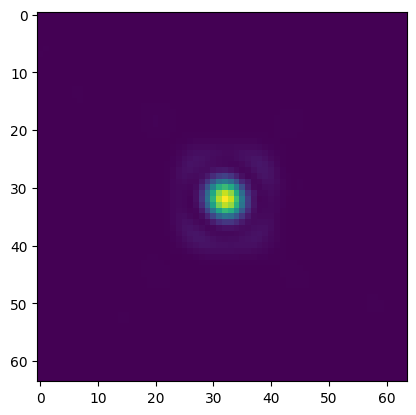

In [7]:
plt.imshow(image)

# Image translation

2023-07-11 13:41:48.617519: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (34)
2023-07-11 13:41:48.617549: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (7a18ebe19f2a): /proc/driver/nvidia/version does not exist
2023-07-11 13:41:48.617747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensor("Reshape:0", shape=(4096, 2), dtype=int32)
Tensor("image:0", shape=(64, 64), dtype=float32)
Tensor("GatherNd:0", shape=(4096,), dtype=float32)


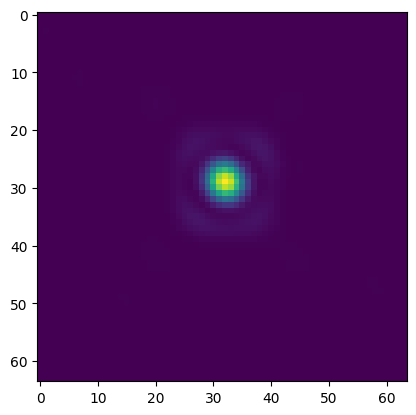

In [8]:
@tf.function
def translate_image(image, dxdy=[0, 0], dtype=tf.int32):
    dxdy = tf.cast(dxdy, dtype=dtype)
    dxdy = tf.reverse(dxdy, axis=[0])
    inp_shape = tf.cast(tf.shape(image), dtype=dtype)
    height = inp_shape[0]
    width  = inp_shape[1]
        
    X = tf.range(0, width, dtype=dtype)
    Y = tf.range(0, height, dtype=dtype)
            
    indices = tf.meshgrid(X, Y)
    indices = tf.stack(indices, -1)
    indices = tf.reshape(indices, [height*width, 2])          
    print(indices)
    print(image)
    values = tf.gather_nd(image, indices)
    print(values)
    shifted_indices = indices + dxdy
    
    dx = tf.slice(shifted_indices, [0, 0], [-1, 1])
    dx = tf.squeeze(dx, -1)
    
    dy = tf.slice(shifted_indices, [0, 1], [-1, 1])
    dy = tf.squeeze(dy, -1)

    cond_x0 = tf.where(dx < width, True, False)
    cond_x1 = tf.where(dx>0, True, False)
    
    cond_y0 = tf.where(dy < height, True, False)
    cond_y1 = tf.where(dy>0, True, False)
    mask_x = tf.math.logical_and(cond_x0, cond_x1)
    mask_y = tf.math.logical_and(cond_y0, cond_y1)
    mask = tf.math.logical_and(mask_x, mask_y)
    
    selected_indices = tf.boolean_mask(shifted_indices,  mask)
    selected_values  = tf.boolean_mask(values,  mask)
    

    translated = tf.scatter_nd(
        selected_indices, selected_values, inp_shape, name=None
    )
    return translated


image_translated = translate_image(image, dxdy=[0, -3])
plt.imshow(image_translated)

In [9]:
@tf.function
def translate_image_batch(image, dxdy=[[0, 0]], dtype=tf.int32):
    dxdy = tf.cast(dxdy, dtype=dtype)
    dxdy = tf.reverse(dxdy, axis=[1])
    inp_shape = tf.cast(tf.shape(image), dtype=dtype)
    n_imgs = inp_shape[0]
    height = inp_shape[1]
    width  = inp_shape[2]
    
    image = tf.transpose(image, [2, 1, 0])
    
    X = tf.range(0, width, dtype=dtype)
    Y = tf.range(0, height, dtype=dtype)
            
    indices = tf.meshgrid(X, Y)
    indices = tf.stack(indices, -1)
    indices = tf.reshape(indices, [height*width, 2])
    
    values = tf.gather_nd(image, indices)
    values = tf.transpose(values, [1, 0])

    indices = tf.expand_dims(indices, 1) 
    shifted_indices = indices + dxdy*[-1, 1]
    
    greater_than_0 = tf.where(shifted_indices>=[0, 0], 1, 0)
    within_image_dimension = tf.where(shifted_indices<[height, width], 1, 0)
    
    mask = greater_than_0 * within_image_dimension 
    mask = tf.reduce_prod(mask, 2)  

    mask = tf.minimum(mask, 1)
    
    mask = tf.transpose(mask)
    valid_values  = values * tf.cast(mask, tf.float32)
    
    shifted_indices = tf.transpose(shifted_indices, [1, 0, 2])
    shifted_indices = shifted_indices * tf.expand_dims(mask, -1)
        
    
    translated = tf.map_fn(lambda x:tf.scatter_nd(x[0], x[1], [height, width]),
                           (shifted_indices, valid_values), fn_output_signature=tf.float32)

    return translated
    

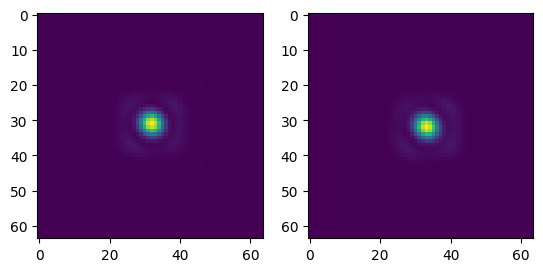

In [11]:
translated = translate_image_batch(image_batch, 
                                   dxdy=[[0, 1], 
                                         [1, 0]])

fig, axes = plt.subplots(1, 2)
for i, x in enumerate(translated):
    axes[i].imshow(x)

# Gaussian float-point centering

In [57]:
from core.data import get_companions
from core.engine import preprocess

In [130]:
table, cube, psf = preprocess('./data/real/HCI/')
table

,x,y,flux,fwhm_mean,snr
0,97.736453,97.652951,15.454168,3.057854,2.315324
1,90.979734,87.349372,31.502232,4.559094,4.930584
2,107.778093,96.231151,10.873409,5.206998,2.145638
3,95.503925,105.822525,0.821423,1.311220,0.559511


In [257]:
row_index = 1
window_size = 20
companions = get_companions(cube, 
                            x=table.iloc[row_index]['x'], 
                            y=table.iloc[row_index]['y'], 
                            window_size=window_size)
flux = table.iloc[1]['flux']
single_comp = companions[0]
inp_shape = tf.shape(single_comp)

In [115]:
@tf.function
def gauss_model(params, mean, scale, amplitude):
    f = tf.exp(-((params[:, 0]-mean[0])**2/(2*scale[0]**2) + (params[:, 1]-mean[1])**2/(2*scale[1]**2)))
    return amplitude*f

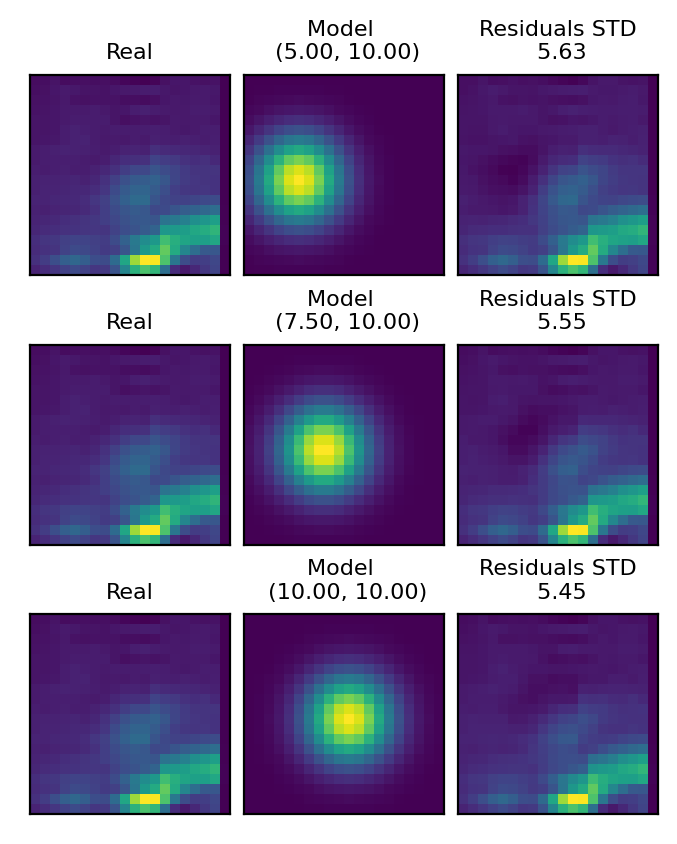

In [129]:
N_shifts = 3
fig, axes = plt.subplots(N_shifts, 3, sharex=True, sharey=True, dpi=200,
                        gridspec_kw={'hspace': 0.35, 'wspace': -0.62})

dx = tf.linspace(-5., 0., N_shifts)

mid_x = tf.cast(inp_shape[-1]//2, tf.float32)
mid_y = tf.cast(inp_shape[-2]//2, tf.float32)

for i in range(N_shifts):
    indices = tf.cast(tf.where(single_comp+1e-9), tf.float32)
    gaus = gauss_model(params=indices, mean=[mid_y, mid_x+dx[i]], scale=[3,3], amplitude=3.)
    gaus = tf.reshape(gaus, [inp_shape[0], inp_shape[1]])
    
    axes[i][0].imshow(single_comp)
    axes[i][0].set_title('Real', fontsize=8)
    axes[i][1].imshow(gaus)
    axes[i][1].set_title('Model \n ({:.2f}, {:.2f})'.format(mid_x+dx[i], mid_y), fontsize=8)
    
    residuals = single_comp - gaus
    std_res = tf.math.reduce_std(residuals)

    axes[i][2].imshow(residuals)
    axes[i][2].set_title('Residuals STD\n {:.2f}'.format(std_res), fontsize=8)
    
    axes[i][2].set_xticks([])
    axes[i][2].set_yticks([])

# Interpolation

In [258]:
row_index = 1
window_size = 20
companions = get_companions(cube, 
                            x=table.iloc[row_index]['x'], 
                            y=table.iloc[row_index]['y'], 
                            window_size=window_size)
norm_psf = get_companions(psf, 
                            x=psf.shape[-1]//2, 
                            y=psf.shape[-1]//2, 
                            window_size=window_size)

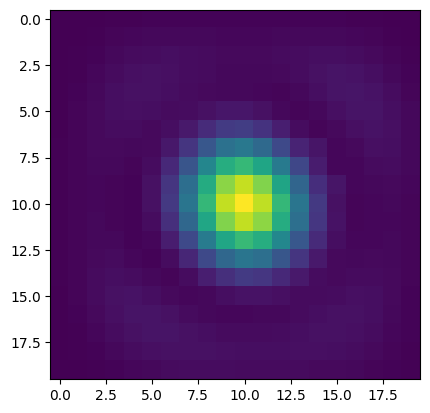

In [259]:
plt.imshow(norm_psf[0])

In [260]:
import numpy as np
from scipy.ndimage import map_coordinates


def shift_image(image, shift):
    # Determine the dimensions of the image
    num_dims = len(image.shape)
    
    # Generate coordinate arrays for each dimension
    coords = np.meshgrid(*[np.arange(size) for size in image.shape], indexing='ij')
    
    # Calculate the shifted coordinates using the shift values
    shifted_coords = [coord + shift[axis] for axis, coord in enumerate(coords)]
    
    # Perform interpolation using map_coordinates
    shifted_image = map_coordinates(image, shifted_coords, order=1, mode='mirror', cval=0.0)
    
    return shifted_image

In [261]:
single_comp.shape

(20, 20)

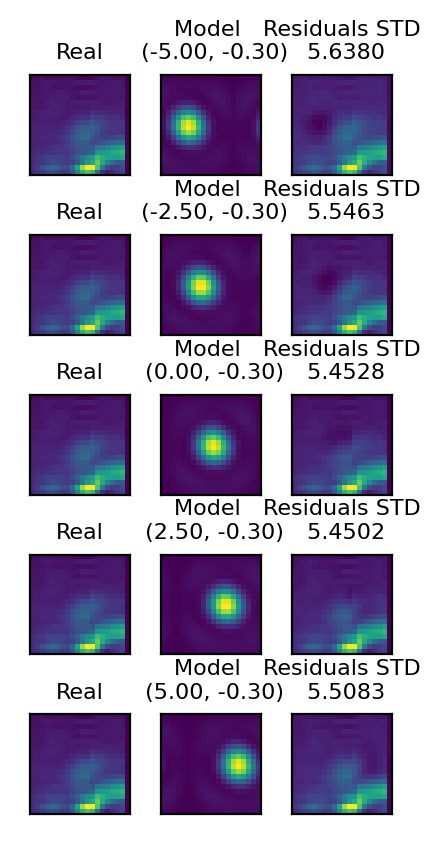

In [292]:
N_shifts = 5
fig, axes = plt.subplots(N_shifts, 3, sharex=True, sharey=True, dpi=200,
                        gridspec_kw={'hspace': 0.6, 'wspace': -0.82})

dx = tf.linspace(-5, 5, N_shifts)
dy = -0.3
for i in range(N_shifts):
    gaus = tf.numpy_function(shift_image, (norm_psf[0], [-dy, -dx[i]]), tf.float32)
    gaus = gaus * flux*2.
    
    axes[i][0].imshow(single_comp)
    axes[i][0].set_title('Real', fontsize=8)
    
    axes[i][1].imshow(gaus)
    axes[i][1].set_title('Model \n ({:.2f}, {:.2f})'.format(dx[i], dy), fontsize=8)
    
    residuals = single_comp - gaus
    std_res = tf.math.reduce_std(residuals)

    axes[i][2].imshow(residuals)
    axes[i][2].set_title('Residuals STD\n {:.4f}'.format(std_res), fontsize=8)
    
    axes[i][2].set_xticks([])
    axes[i][2].set_yticks([])